---

## **Introduction**

### **Montecarlo Method in Grid World**

I implemented a code to apply **Monete carlo** in a grid world

<br>

**Policy iteration** and **Value iteration** require information about dynamics, meaning they are model-based methods. However, the **Monte Carlo method** does not require a model. By directly experiencing **trial and error**, it computes the value function or action value function and improves the policy to find the optimal policy.

<br>

---

<br>

The grid world map is structured as follows:

- The game `starts` at the **Door** position.
- **Walls** are `impassable`.
- Passing through **Radiation** incurs a `penalty`.
- Reaching the **Treasure** position grants a `reward` and `ends the game.`

<img src="https://drive.google.com/uc?export=view&id=1UyixvvHu-hOYDmUtHK_ko5pjLUZWnAg1" alt="Gridworld" width="400">

---


In [20]:
import numpy as np
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

class GridWorld:
  def __init__(self, policy):
    self.policy = policy # example: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25} action: probability
    self.wall_map = np.array([
        ['wall',  0,     'wall',  0,     0],
        [0,       0,     0,       0,     'wall'],
        [0,       'wall', 0,      'wall', 'wall'],
        [0,       0,     0,       0,     'wall'],
        [0,       0,     0,       0,     0]])
    wall_indices = np.where(self.wall_map == 'wall')
    self.wall_cordinates = list(zip(wall_indices[0], wall_indices[1]))
    self.reward_map = np.array([
        [0, 0, 0, 0, 1],
        [-1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, -1, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ])
    penalty_indices = np.where(self.reward_map < 0)
    self.penalty_cordinates = list(zip(penalty_indices[0], penalty_indices[1]))
    self.action_mean = {
        0: 'UP',
        1: 'DOWN',
        2: 'LEFT',
        3: 'RIGHT'}
    self.action_move = {
        0: (-1, 0),
        1: (+1, 0),
        2: (0, -1),
        3: (0, +1)}
    self.action_arrows = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    self.start_state = (4, 0)
    self.value_map = np.zeros(shape = (5, 5))
    self.terminal_state = (0, 4)
    self.grid_limit = (self.height - 1, self.width - 1)
    self.gamma = 0.9
    self.ns = np.zeros(shape = (self.height, self.width))
    self.history = []

  def montecarlo_one_epiosde(self):
    current_state = self.start_state
    self.history = []
    # 아래를 반복
    while True:
      action = self.get_action(current_state)

      next_state = self.next_state(current_state, action)
      reward = self.reward_map[next_state]
      self.history.append((current_state, action, reward))

      if next_state == self.terminal_state:
        break

      current_state = next_state


  def get_action(self, state):
    actions_list = list(self.policy[state].keys())
    probs_list = list(self.policy[state].values())
    action = np.random.choice(actions_list, p = probs_list)

    return action

  def next_state(self, current_state, action):
    (y, x) = current_state
    (dy, dx) = self.action_move[action]
    next_state = (y + dy, x + dx)
    next_state = (
        max(0, min(self.grid_limit[0], next_state[0])),
        max(0, min(self.grid_limit[1], next_state[1])))
    if next_state in self.wall_cordinates:  # If the next state is a wall, stay in the current state
      next_state = current_state
    return next_state


  def render(self, policy_show=True):
    plt.figure(figsize=(10, 8))
    """
    Visualize the grid world with value function and optional policy arrows
    """
    vmin = np.min(self.value_map)
    vmax = np.max(self.value_map)
    colors = ["red", "white", "green"]  # 빨강-흰색-초록
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    plt.pcolormesh(np.flipud(self.value_map), cmap=custom_cmap, vmin=vmin, vmax=vmax, alpha=0.8)

    for y in range(self.height):
      for x in range(self.width):
        if (y, x) in self.wall_cordinates:
          plt.text(
                x + 0.5, self.height - y - 0.5, "Wall",
                ha="center", va="center", fontsize=20, color="purple", fontweight = 'bold')
        else:
          if (y, x) == self.terminal_state:
            plt.text(
              x + 0.5, self.height - y - 0.5,
              "Goal",
              ha="center", va="center", fontsize=35, color="gold", fontweight = 'bold')
          else:
            if (y, x) in self.penalty_cordinates:
              plt.text(
                x + 0.2, self.height - y - 0.7,
                "radiation",
                ha="left", va="top", fontsize=13, color="black", fontweight = 'bold')
            plt.text(
                x + 0.1, self.height - y - 0.1,
                f"Value: {self.value_map[y, x]: .4f}",
                ha="left", va="top", fontsize=10, color="black")
            if (y, x) == self.start_state:
              plt.text(
                x + 0.5, self.height - y - 0.7,
                "Start Here",
                ha="center", va="center", fontsize=15, color="blue", fontweight = 'bold')
            offsets = {
                      0: (+0.1, 0),  # Up
                      1: (-0.13, 0),   # Down
                      2: (0, -0.1),  # Left
                      3: (0, +0.1)}  # Right
            for action in self.policy[y, x]:
              dy, dx = offsets[action]
              if self.policy[y, x][action] != 0:
                plt.text(
                    x + 0.5 + dx, self.height - y - 0.5 + dy,
                    f"{self.action_arrows[action]}",
                    ha="center", va="center", fontsize=30, color="black")

    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    # Add grid lines manually
    plt.gca().set_xticks(np.arange(self.width + 1), minor=True)
    plt.gca().set_yticks(np.arange(self.height + 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.7)

    plt.title("GridWorld Map, Policy Iteration", fontsize=16)
    plt.show()

  @property
  def height(self):
    return self.reward_map.shape[0]

  @property
  def width(self):
    return self.reward_map.shape[1]

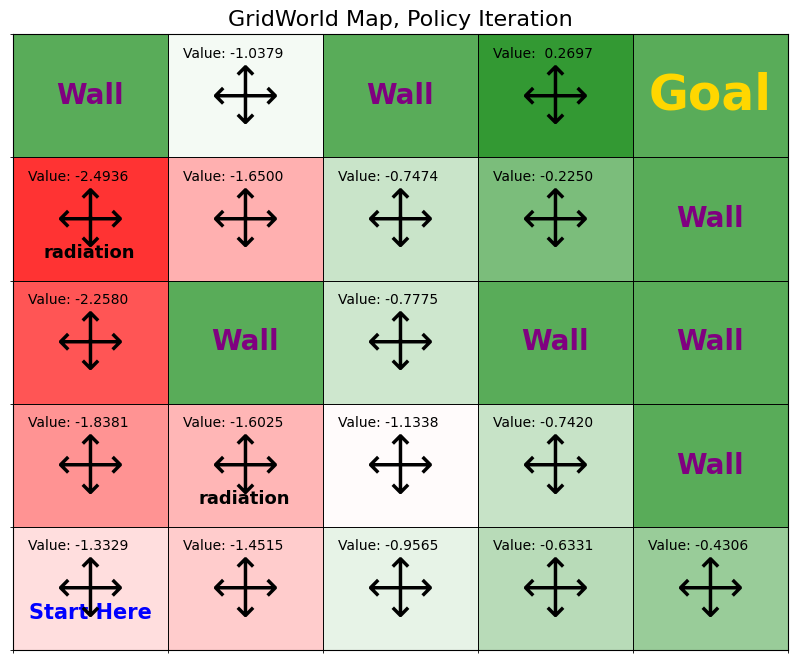

In [21]:
from collections import defaultdict

random_policy = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
game = GridWorld(random_policy)

total_episode = 100
for episode in range(total_episode):

  game.montecarlo_one_epiosde()
  G = 0
  for data in reversed(game.history):
    state, action, reward = data
    G = reward + game.gamma * G
    game.ns[state] += 1
    game.value_map[state] += 1/game.ns[state] * (G - game.value_map[state])

game.render()

---

## **Conclusion**

Under a **random policy**, it was observed that

**nearly identical** to those obtained by solving the **Bellman Optimal Equation**  using the [**Dynamic Programming (DP) method**](https://github.com/LeeJunho-AI/Reinforcement_Learning_Study/blob/main/03_GridWorld_DP.ipynb)

<br>

---